# Load modules

In [1]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt

# Load file with resolved tidal data

In [2]:
NC = netCDF4.Dataset('warner.3d.nc')
time = NC.variables['time'][1:] # exclude initial tidal snapshot (avoid double-counting during tidal averaging)
dx = NC.variables['dx'][:]
dy = NC.variables['dy'][:]

## Location of cross-section

In [3]:
i = 45 ; j = 0

In [4]:
xcl = NC.variables['xc'][i]
xcr = NC.variables['xc'][i+1]
xci = 0.5 * ( xcl + xcr ) # average to U-point interface between center cells
print( 'Analyze cross-section ', xci/1000, ' km upstream of open boundary.' )

Analyze cross-section  22.5  km upstream of open boundary.


## Analyze water depth

Read bathymetry (water depth below z=0):

In [5]:
bathyl = NC.variables['bathymetry'][j,i]
bathyr = NC.variables['bathymetry'][j,i+1]
bathyi = 0.5 * ( bathyl + bathyr ) # average to U-point interface between center cells

Read time-varying sea surface elevation (water height above z=0):

In [6]:
elevl = NC.variables['elev'][:,j,i]
elevr = NC.variables['elev'][:,j,i+1]
elevi = 0.25 * ( elevl[:-1] + elevl[1:] + elevr[:-1] + elevr[1:] ) # average in space and time

Calculate time-varying water depth:

In [7]:
Di = bathyi + elevi

Calculate mean water depth:

In [8]:
Di_mean = Di.mean()

Show in a plot:

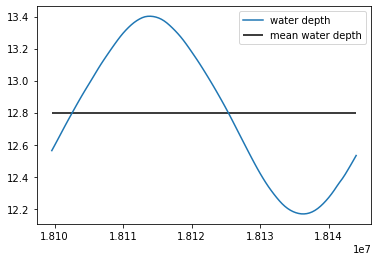

In [9]:
plt.plot( time , Di , label = 'water depth' )
plt.hlines( Di_mean , xmin = time[0] , xmax = time[-1] , label = 'mean water depth' , color = 'k' )
plt.legend()
plt.show()

## Analyze depth-averaged velocity

time-varying depth-averaged velocity:

In [10]:
u2d = NC.variables['u'][1:,j,i]

In [11]:
u2d_mean = u2d.mean()
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-averaged velocity is <u2d> = -0.01744917


Show in a plot:

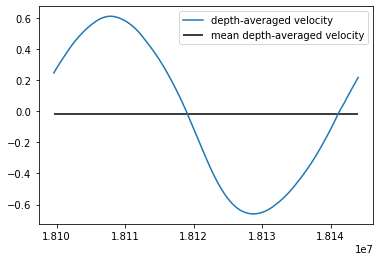

In [12]:
plt.plot( time , u2d , label = 'depth-averaged velocity' )
plt.hlines( u2d_mean , xmin = time[0] , xmax = time[-1] , label = 'mean depth-averaged velocity' , color = 'k')
plt.legend()
plt.show()

## Analyze depth-integrated transport

In [13]:
Di_mean_u2d_mean = Di_mean * u2d_mean
print( 'First guess for mean depth-integrated transport is dy*<D>*<u2d> = ', dy*Di_mean_u2d_mean )

First guess for mean depth-integrated transport is dy*<D>*<u2d> =  -111.63073033094406


Q: Why does this value not reproduce the river input Qr=50 ???  
A: Because we have to calculate `dy*<D*u2d>` !!!

Calculate time-varying depth-integrated transport:

In [14]:
Du2d = Di * u2d

In [15]:
Du2d_mean = Du2d.mean()
print( 'Mean depth-integrated transport is dy*<D*u2d> =', dy*Du2d_mean )

Mean depth-integrated transport is dy*<D*u2d> = -51.95033550262451


Q: Why is there still a deviation between `dy*<D*u2d>` and Qr ???  
A: Slightly non-periodic model state

Plot:

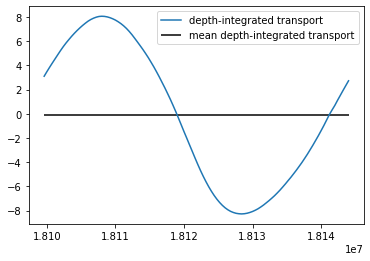

In [16]:
plt.plot( time , Du2d , label = 'depth-integrated transport')
plt.hlines( Du2d_mean , xmin = time[0] , xmax = time[-1] , label = 'mean depth-integrated transport' , color = 'k')
plt.legend()
plt.show()

## Define mean transport velocity

In [17]:
u2d_twa = Du2d_mean / Di_mean
print( 'Mean depth-integrated transport velocity is <D*u2d>/<D> =', u2d_twa )
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-integrated transport velocity is <D*u2d>/<D> = -0.008120437
Mean depth-averaged velocity is <u2d> = -0.01744917


`u2d_twa = <D*u2d>/<D>` is the correct velocity associated with the volume transport !!!

## First guess for Qin and Qout

In [18]:
Du2d_in  =  np.fmax( 0 , Du2d ) # only consider positive transports
Du2d_out = -np.fmin( Du2d , 0 ) # only consider negative transports
Du2d_in_mean  = Du2d_in.mean()
Du2d_out_mean = Du2d_out.mean()
print( 'First guess for Qin is dy*<(D*u2d)^+> =', dy*Du2d_in_mean )
print( 'First guess for Qout is -dy*<(D*u2d)^-> =', dy*Du2d_out_mean )

First guess for Qin is dy*<(D*u2d)^+> = 1272.9873657226562
First guess for Qout is -dy*<(D*u2d)^-> = 1324.9376841953822


## Check volume balance

In [19]:
t0 = NC.variables['time'][ 0]
t1 = NC.variables['time'][-1]
bathy = NC.variables['bathymetry'][j,i+1:]
elev0 = NC.variables['elev'][ 0,j,i+1:]
elev1 = NC.variables['elev'][-1,j,i+1:]
D0 = bathy + elev0
D1 = bathy + elev1
V0 = D0.sum() * dx * dy
V1 = D1.sum() * dx * dy
print(' dV/dt =', ( V1 - V0 ) / ( t1 - t0 ) )
print(' Qin - Qout + Qr =', dy * ( Du2d_in_mean - Du2d_out_mean ) + 50 )

 dV/dt = 0.039201612318200726
 Qin - Qout + Qr = -1.950318472725911


==> Slightly non-periodic state dV/dt<>0 (could be avoided by averaging over more tidal cycles) !!!  
==> Volume balance is ok (single precision errors can be avoided with `-D_NCDF_SAVE_DOUBLE_`) !!!